### Preparando os dados

In [1]:
# Unquoting data 
from urllib.parse import unquote

files = ['links', 'categories', 'paths_finished']

for i in files:
    text_file = open(f'./my_data/wiki/{i}.csv', "r")
    data = text_file.read()
    text_file.close()

    unquoted_data = unquote(data)

    f = open(f'./my_data/wiki/{i}_unquoted.csv', "a")
    f.write(unquoted_data)
    f.close()


In [2]:
## Create dataframes from links file
import networkx as nx
import pandas as pd
import numpy as np

# Read the edge list from the file
df1 = pd.read_csv('./my_data/wiki/links_unquoted.csv', delimiter=';', header = None)

### Definição de funções

In [3]:
import matplotlib.pyplot as plt
from operator import itemgetter
#%matplotlib inline

def show_histogram(xvalues=None, yvalues=None, figsize=(5,5), xlabel='Values', ylabel='Count', normalized=False):
    h_deg = xvalues
    if xvalues == None:
        h_deg = list( range(0, len(yvalues)) )
    v_deg = yvalues
    if yvalues == None:
        v_deg = list( range(0, len(xvalues)) )
    plt.figure(figsize=figsize, tight_layout = True)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)    
    plt.xticks(rotation = 60)
    plt.bar(h_deg, v_deg, color = 'b') 
    plt.show()

def histogram_attribute(graph, attr):
    categories_list = vectorize_attr(graph, attr)
    x = []

    for item in categories_list:
        if item not in [row[0] for row in x]:
            x.append((item, 1))
        else:
            idx = [row[0] for row in x].index(item)
            x[idx] = (item, x[idx][1]+1)

    x = sorted(x, key=itemgetter(1), reverse=True)
    print(x)

    show_histogram(yvalues=[row[1] for row in x], xvalues=[row[0] for row in x], figsize=(15,8), xlabel=f'{attr} count', ylabel=f'Pages with {attr}')

def vectorize_attr(graph, attr):
    node_attrs = nx.get_node_attributes(graph, name=attr)
    c = []
    for item in node_attrs:
        c = c + node_attrs[item]
    return c

# Hyperlinks on Wikipedia

Esta é uma rede de páginas da Wikipedia, onde os nós são páginas e as arestas representam hyperlinks entre duas páginas. É uma rede que representa um subconjunto da wikipedia, contendo 4096 páginas e 106647 links.
A rede foi criada para ser utilizada no jogo Wikispeedia, onde eram dadas aos jogadores uma página inicial e uma página alvo e os jogadores deveriam, partindo da página inicial, chegar à página alvo navegando pelos links entre as páginas.
Foram coletados dados dos caminhos percorridos pelos jogadores bem como os caminhos que não foram concluídos.
Cada página também contém um atributo chamado categoria, que classifica o conteúdo da página (história, química, música etc). 

Fonte: https://snap.stanford.edu/data/wikispeedia.html

### Montagem do grafo

Cada página será um nó e se uma página A contem um link para uma página B então é inserida uma aresta direcionada A -> B.
Porém o grafo é não direcionado devido à sessão de referências.
Cada nó possui os atributos **Category** e **Macrocategory** classificando a página de acordo com o tema.

Exemplos de categorias e subcategorias:

 - **Página**: Brazil
   - **Category**: subject.Geography.Central_and_South_American_Geography.Central_and_South_American_Countries
   - **MacroCategory**: Geography
 - **Página**: Albert_Einstein
   - **Category**: subject.People.Astronomers_and_physicists 
   - **Macrocategory**: People

Assim, cada nó do grafo terá as seguintes propriedades:
  - *valor*: string
  - *grau*: inteiro
  - *atributos*
    - *categoria*: lista de strings
    - *macrocategoria*: lista de strings

In [5]:
## Mount graph

G = nx.Graph()
for i in range(len(df1)):
    G.add_node(df1.loc[i,0], label = df1.loc[i,0], category = [], macrocategory= []) # Add node A with -1 as attribute
    G.add_node(df1.loc[i,1], label = df1.loc[i,1], category = [], macrocategory= []) # Add node B with -1 as attribute
    G.add_edge(df1.loc[i,0], df1.loc[i,1])        # Add edge (A,B) to the network
    

## Add category property to nodes
df2 = pd.read_csv('./my_data/wiki/categories_unquoted.csv', delimiter=';', header = None)

for i in range(len(df2)):

    node_attrs_category = nx.get_node_attributes(G, name='category')
    node_attrs_macrocategory = nx.get_node_attributes(G, name='macrocategory')
    list_category = []
    list_macrocategory = []
    if df2.loc[i,0] in node_attrs_category.keys() and node_attrs_category[df2.loc[i,0]] != None:
        list_category = list(node_attrs_category[df2.loc[i,0]])
        list_category.append(df2.loc[i,1])
        list_macrocategory = list(node_attrs_macrocategory[df2.loc[i,0]])
        list_macrocategory.append(df2.loc[i,1].split('.')[1])
    G.add_node(df2.loc[i,0], label = df2.loc[i,0], category = list_category, macrocategory = list(set(list_macrocategory)))

G.remove_edges_from( nx.selfloop_edges(G) )

[('Science', 1105), ('Geography', 1063), ('People', 676), ('History', 525), ('Everyday_life', 369), ('Design_and_Technology', 247), ('Countries', 229), ('Citizenship', 215), ('Language_and_literature', 194), ('Religion', 131), ('Music', 97), ('Business_Studies', 87), ('IT', 84), ('Mathematics', 45), ('Art', 38)]


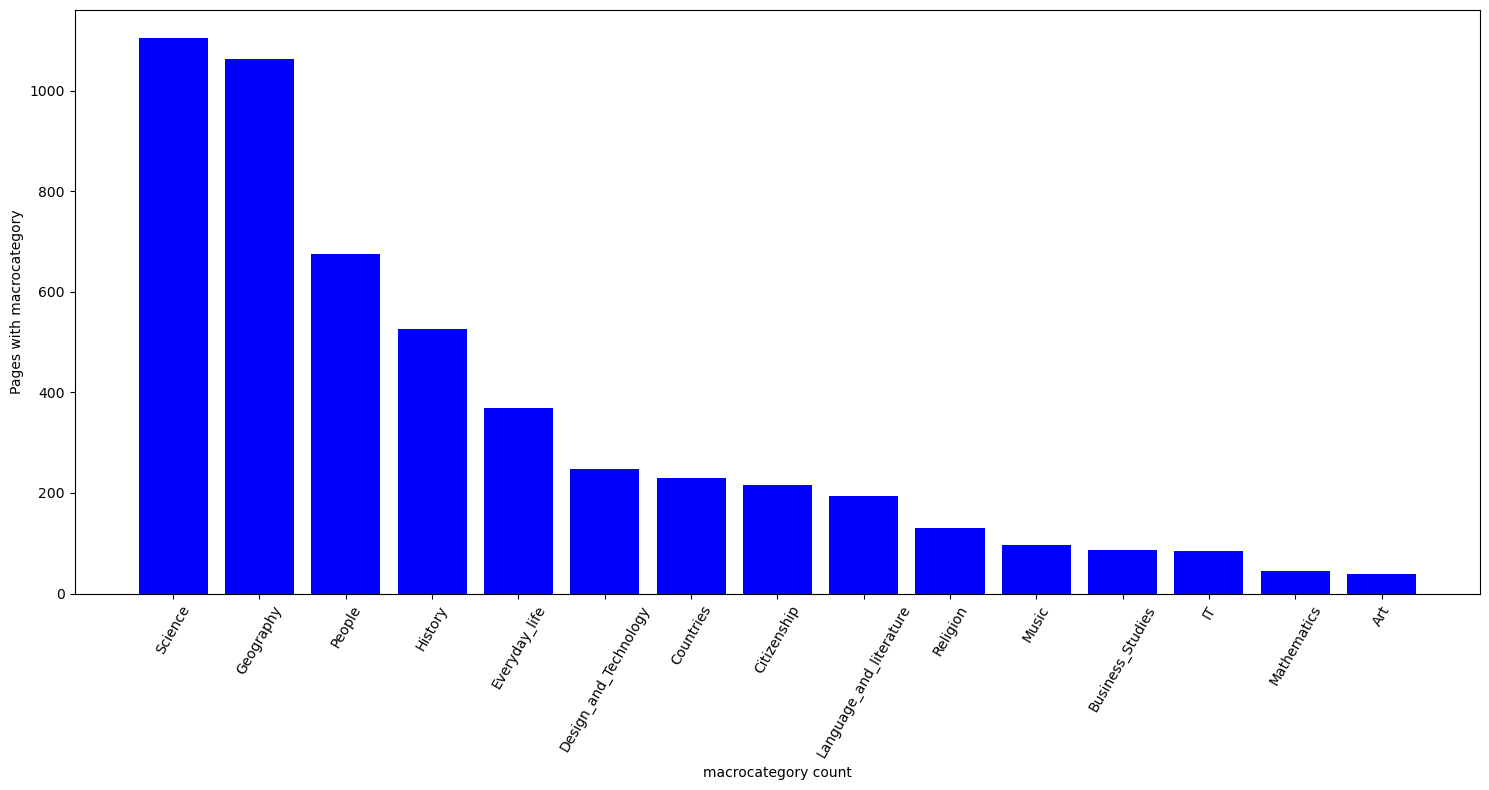

In [9]:
## Macro-Category distribution
from operator import itemgetter

histogram_attribute(G, 'macrocategory')

[('subject.Countries', 4122), ('subject.Science.Biology.Birds', 2898), ('subject.Geography.Geography_of_Great_Britain', 2232), ('subject.Science.Chemistry.Chemical_elements', 2142), ('subject.Science.Biology.Mammals', 2052), ('subject.Science.Biology.Health_and_medicine', 1961), ('subject.People.Historical_figures', 1944), ('subject.Science.Biology.Plants', 1944), ('subject.Science.Physics.Space_Astronomy', 1890), ('subject.Geography.North_American_Geography', 1854), ('subject.Citizenship.Politics_and_government', 1746), ('subject.Everyday_life.Food_and_agriculture', 1746), ('subject.History.Ancient_History_Classical_History_and_Mythology', 1566), ('subject.Design_and_Technology.Railway_transport', 1512), ('subject.Geography.European_Geography', 1494), ('subject.History.General_history', 1440), ('subject.Geography.African_Geography', 1440), ('subject.Geography.Geology_and_geophysics', 1368), ('subject.Design_and_Technology.Engineering', 1332), ('subject.History.British_History.British_

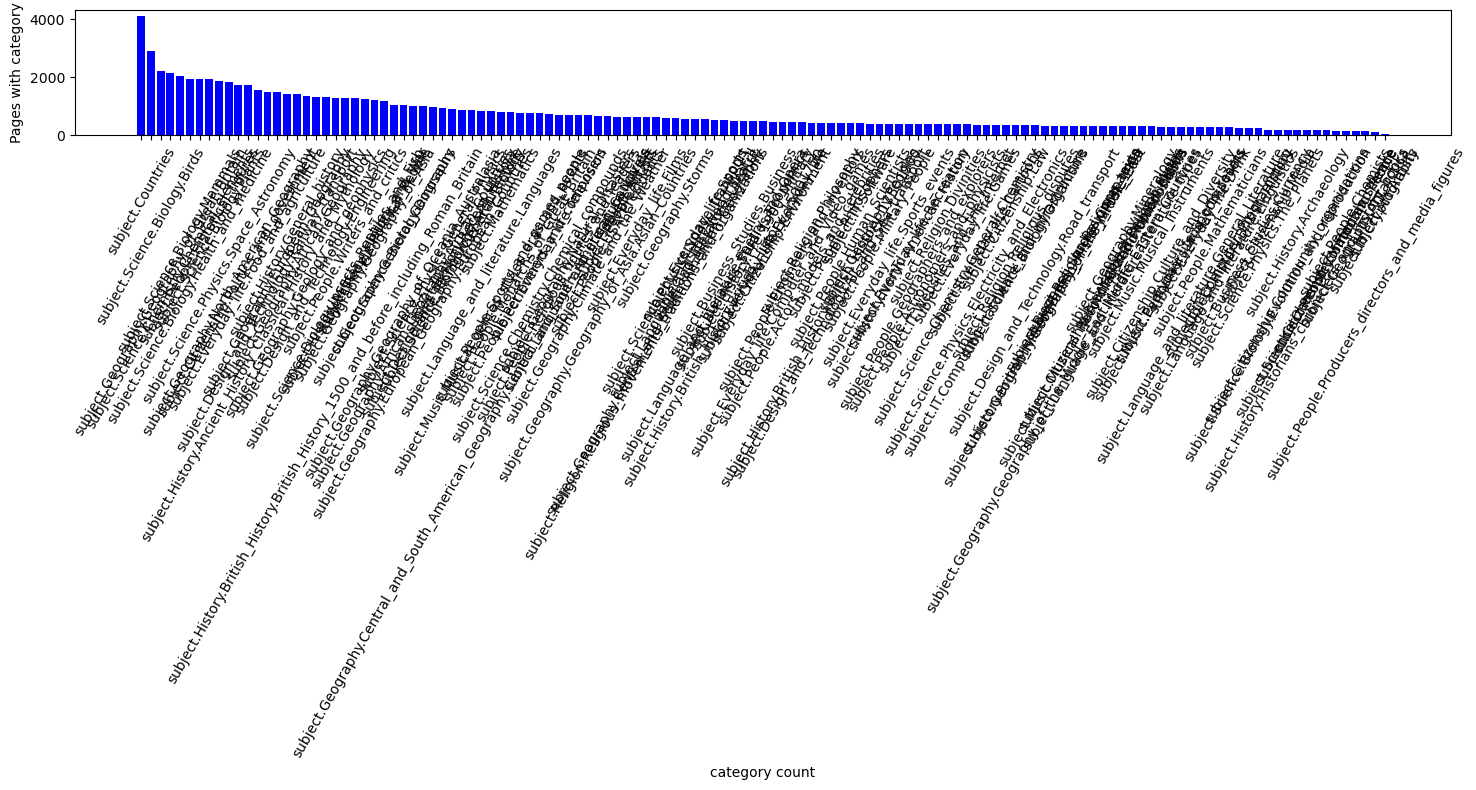

In [7]:
## Category distribution
histogram_attribute(G, 'category')

## Degree Analisys

In [8]:
## Number of nodes and edges
print("Number of nodes: %d" %G.number_of_nodes() )
print("Number of edges: %d" %G.number_of_edges() )
print(f'Average Degree: {sum([degree[1] for degree in G.degree()])/G.number_of_nodes()}')
sorted_degrees = sorted(G.degree(), key=itemgetter(1), reverse=True)
print(f'Max degree: {sorted_degrees[0][1]} in node {sorted_degrees[0][0]}')

'''# In degree
print(f'Average In Degree: {sum([degree[1] for degree in G.in_degree()])/G.number_of_nodes()}')
sorted_in_degrees = sorted(G.degree(), key=itemgetter(1), reverse=True)
print(f'Max In degree: {sorted_in_degrees[0][1]} in node {sorted_in_degrees[0][0]}')

# Out degree
print(f'Average Out Degree: {sum([degree[1] for degree in G.out_degree()])/G.number_of_nodes()}')
sorted_out_degrees = sorted(G.degree(), key=itemgetter(1), reverse=True)
print(f'Max Out degree: {sorted_out_degrees[0][1]} in node {sorted_out_degrees[0][0]}')'''

Number of nodes: 4602
Number of edges: 106647
Average Degree: 46.348109517601046
Max degree: 1621 in node United_States


"# In degree\nprint(f'Average In Degree: {sum([degree[1] for degree in G.in_degree()])/G.number_of_nodes()}')\nsorted_in_degrees = sorted(G.degree(), key=itemgetter(1), reverse=True)\nprint(f'Max In degree: {sorted_in_degrees[0][1]} in node {sorted_in_degrees[0][0]}')\n\n# Out degree\nprint(f'Average Out Degree: {sum([degree[1] for degree in G.out_degree()])/G.number_of_nodes()}')\nsorted_out_degrees = sorted(G.degree(), key=itemgetter(1), reverse=True)\nprint(f'Max Out degree: {sorted_out_degrees[0][1]} in node {sorted_out_degrees[0][0]}')"

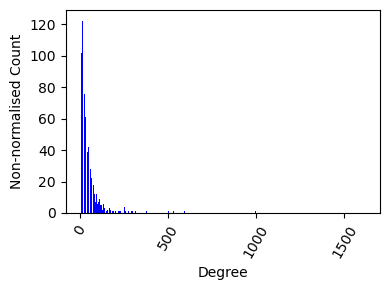

In [9]:
# Plot the degree distribution
show_histogram(yvalues=nx.degree_histogram(G), figsize = (4,3), ylabel='Non-normalised Count', xlabel='Degree')


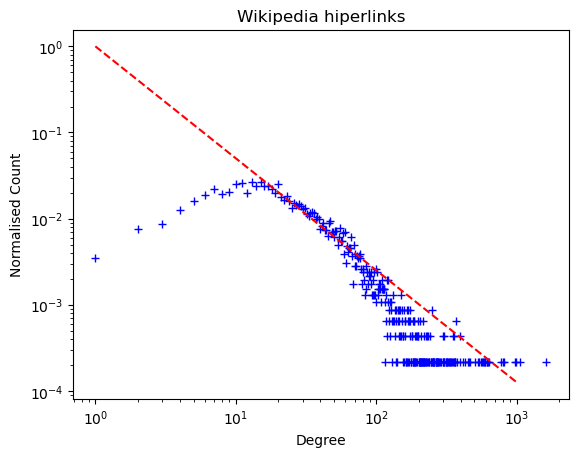

In [10]:
## Degree distribution (log)
import networkx as nx
import matplotlib.pyplot as plt

# REMOVE MULTIPLE EDGES AND SELF-LOOPS
G = nx.Graph(G)                                 # Remove multiple edges
G.remove_edges_from( nx.selfloop_edges(G) )     # Remove self-loops

# Make the histogram of degree, i.e. the number of nodes with a certain degree
h_deg = nx.degree_histogram(G)                              # calculate the degree histogram
h_deg_n = [x / nx.number_of_nodes(G) for x in h_deg]        # normalise the histogram to make a pdf
v_deg = list( range(0,len(h_deg)))                          # create a list of degree values, from 0 to len(h_deg)

# Draw the histogram, using log-scale on the axes (why? try without log-scale)
plt.title('Wikipedia hiperlinks')
plt.ylabel('Normalised Count')
plt.xlabel('Degree')
plt.yscale('log')
plt.xscale('log')
#plt.bar(v_deg, h_deg_n, width=0.8, color='b')  # this plot using "bars", but "bars" are not good when using log-scale in the axes - DO NOT USE IT UNLESS THE HISTOGRAM IS SMALL!
plt.plot(v_deg, h_deg_n, 'b+')

# Draw an eye-guide curve. In this case a power-law with exponent 1.8
list_x = list( range(1,1000) )                    # Create the values for the x-axis and convert to a list
list_y = list( [ 1/(i**1.3) for i in list_x ] )   # Create the values for the y-axis and convert to a list:
                                                  # this code is called "list comprehension" [ 1/(i**1.8) for i in list_x ] -> for each item "i" in the list "list_x", the output is "1/(i**1.8)"
plt.plot(list_x, list_y, 'r--')

plt.show()

## Giant component

In [10]:
## Has giant component?

Gcc = sorted( nx.connected_components(G), key=len, reverse=True)
print(f'Number of connected components: {len(Gcc)}')

#for idx in range(len(Gcc)):
#    print(f'Number of nodes of connected component {idx}: {G.subgraph( Gcc[idx] ).number_of_nodes()}')
#    print(f'Number of edges of connected component {idx}: {G.subgraph( Gcc[idx] ).number_of_edges()}')

# Make a subgraph "H" of "G" containing only the giant component, i.e. Gcc[0]
H = G.subgraph( Gcc[0] ).copy()

Number of connected components: 12


A rede possui um componente gigante com 4596 nós. Isso representa aproximadamente 99.86% da rede. Portanto, de agora em diante, usaremos o componente gigante para calcular as demais métricas.

## Centrality metrics

In [11]:
## Centrality metrics
# Some solutions

# Calculate the relevant network measures and organise the data into a dataframe

# Degree centrality -> that is the same as the degree but normalised by N-1
k_cent = nx.degree_centrality(H)

# Betweenness centrality -> normalised by 2/((n-1)(n-2))
b_cent = nx.betweenness_centrality(H)

# Page-Rank centrality
pr_cent = nx.pagerank(H)

# Eigenvector centrality
# but the network in undirected! therefore, better to use eigenvector centrality
# note that the method nx.pagerank() above works with undirected network by assuming that all edges are bidirectional
ev_cent = nx.eigenvector_centrality(H)

# clustering coefficient of each node
cc = nx.clustering(H)

# Save the network measures of each node, that is originally in a dictionary, to dataframes
df1 = pd.DataFrame.from_dict(k_cent, orient='index', columns = ['degree'])
df2 = pd.DataFrame.from_dict(b_cent, orient='index', columns = ['betweenness'])
df3 = pd.DataFrame.from_dict(ev_cent, orient='index', columns = ['eigenvector'])
df4 = pd.DataFrame.from_dict(cc, orient='index', columns = ['clustering'])

# Save the attributes of each node, that are originally stored as node attributes, in dataframes
# Note that here I include the node column to make sure the index will store the node ID
df5 = pd.DataFrame( list(H.nodes(data = 'category') ), columns = ['node','category'])
df5 = df5.set_index('node')


# Combine all dataframes into a single dataframe
network_measures = pd.concat([df1, df2, df3, df4, df5], axis = 1)

pd.set_option('display.max_rows', 20)

network_measures

,degree,betweenness,eigenvector,clustering,category
Áedán_mac_Gabráin,0.002398,1.473365e-06,0.001728,0.581818,[subject.History.British_History.British_Histo...
Bede,0.008065,8.202625e-05,0.003519,0.144144,[subject.History.British_History.British_Histo...
Columba,0.004359,1.141426e-05,0.002519,0.294737,"[subject.People.Religious_figures_and_leaders,..."
Dál_Riata,0.006321,2.689838e-05,0.003020,0.273399,[subject.History.British_History.British_Histo...
Great_Britain,0.044246,2.412929e-03,0.030650,0.068819,"[subject.History.British_History, subject.Citi..."
...,...,...,...,...,...
Yellowhammer,0.002833,1.711574e-05,0.002873,0.282051,"[subject.Science.Biology.Birds, subject.Scienc..."
Yotsuya_Kaidan,0.000436,0.000000e+00,0.000275,1.000000,[subject.Language_and_literature.General_Liter...
You're_Still_the_One,0.000436,4.637280e-08,0.000279,0.000000,[subject.Music.Musical_Recordings_and_composit...
"Yungay,_Peru",0.000872,7.692585e-08,0.000792,0.666667,[subject.Geography.Central_and_South_American_...


## Assortativity

In [12]:
# Assortativity by degree

# for undirected and unweighted networks
r_deg = nx.degree_assortativity_coefficient(H)
print('Assort. by degree: %.2f' % r_deg)

# Assortativity by category
#r_colour = nx.attribute_assortativity_coefficient(H, 'category')
#print('Assort. by category: %.2f' % r_colour)

# Assortativity by macrocategory
#r_colour = nx.attribute_assortativity_coefficient(H, 'macrocategory')
#print('Assort. by macrocategory: %.2f' % r_colour)

Assort. by degree: -0.12


## Path based metrics

In [11]:
print('Diameter: ', nx.diameter(H) )


NameError: name 'H' is not defined

## Cluster coefficient

In [14]:
import pandas as pd

print("avg. cc: %.3f" % nx.average_clustering(H) )

df1 = pd.DataFrame.from_dict(nx.clustering(H), orient='index', columns=['clustering'])
print(df1)

avg. cc: 0.274
                      clustering
Áedán_mac_Gabráin       0.581818
Bede                    0.144144
Columba                 0.294737
Dál_Riata               0.273399
Great_Britain           0.068819
...                          ...
Yellowhammer            0.282051
Yotsuya_Kaidan          1.000000
You're_Still_the_One    0.000000
Yungay,_Peru            0.666667
Zara_Yaqob              0.666667

[4589 rows x 1 columns]


## Other metrics

In [15]:
triangles = nx.triangles(H)
closeness = nx.closeness_centrality(H)
triangles = sorted([(key, triangles[key]) for key in triangles], key=itemgetter(1), reverse=True)
closeness = sorted([(key, closeness[key]) for key in closeness], key=itemgetter(1), reverse=True)

#print('Triangles: ', triangles)
#print('Closeness: ', closeness)
print('Transitivity: %.3f' % nx.transitivity(H))

Transitivity: 0.103


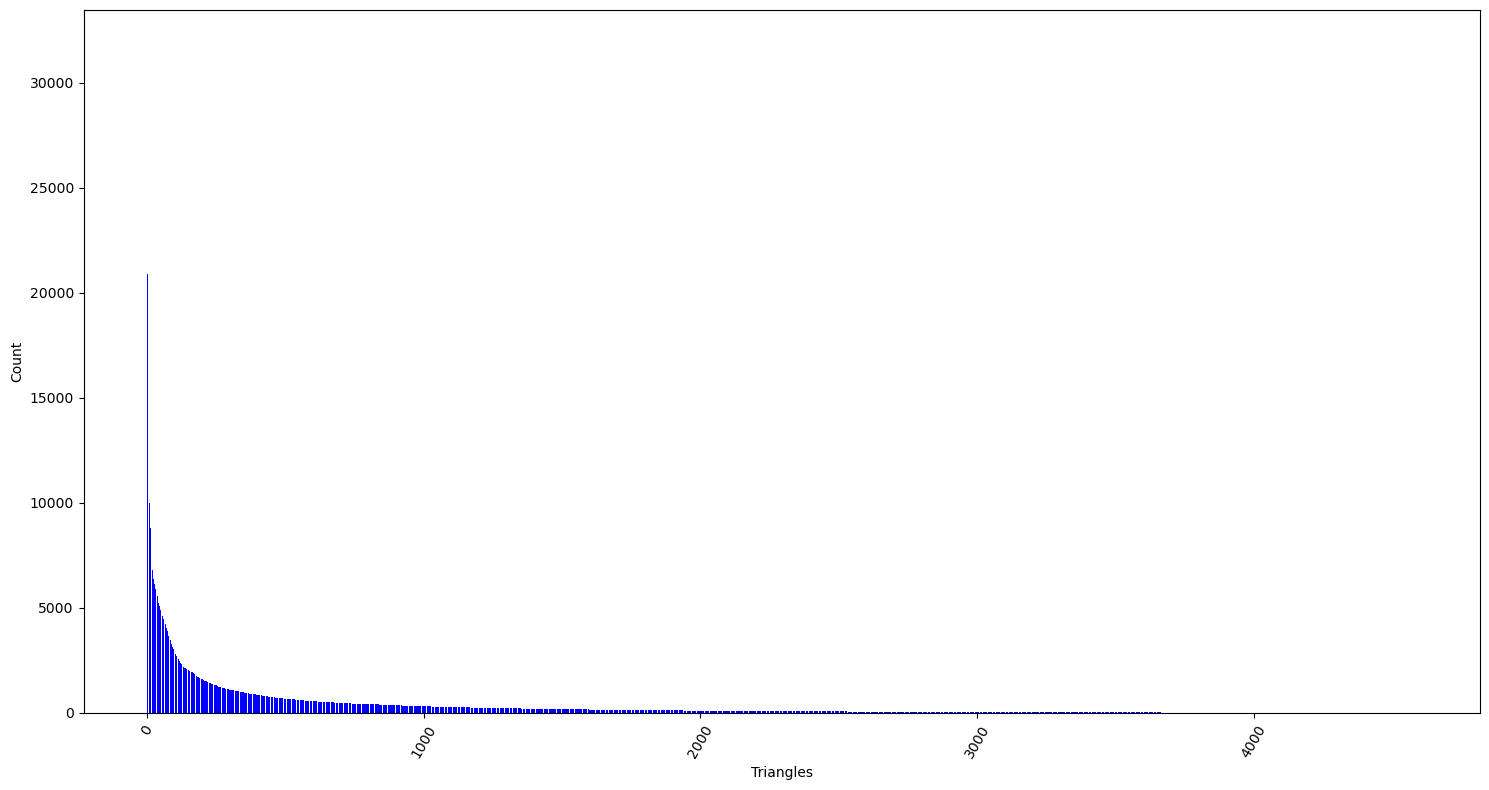

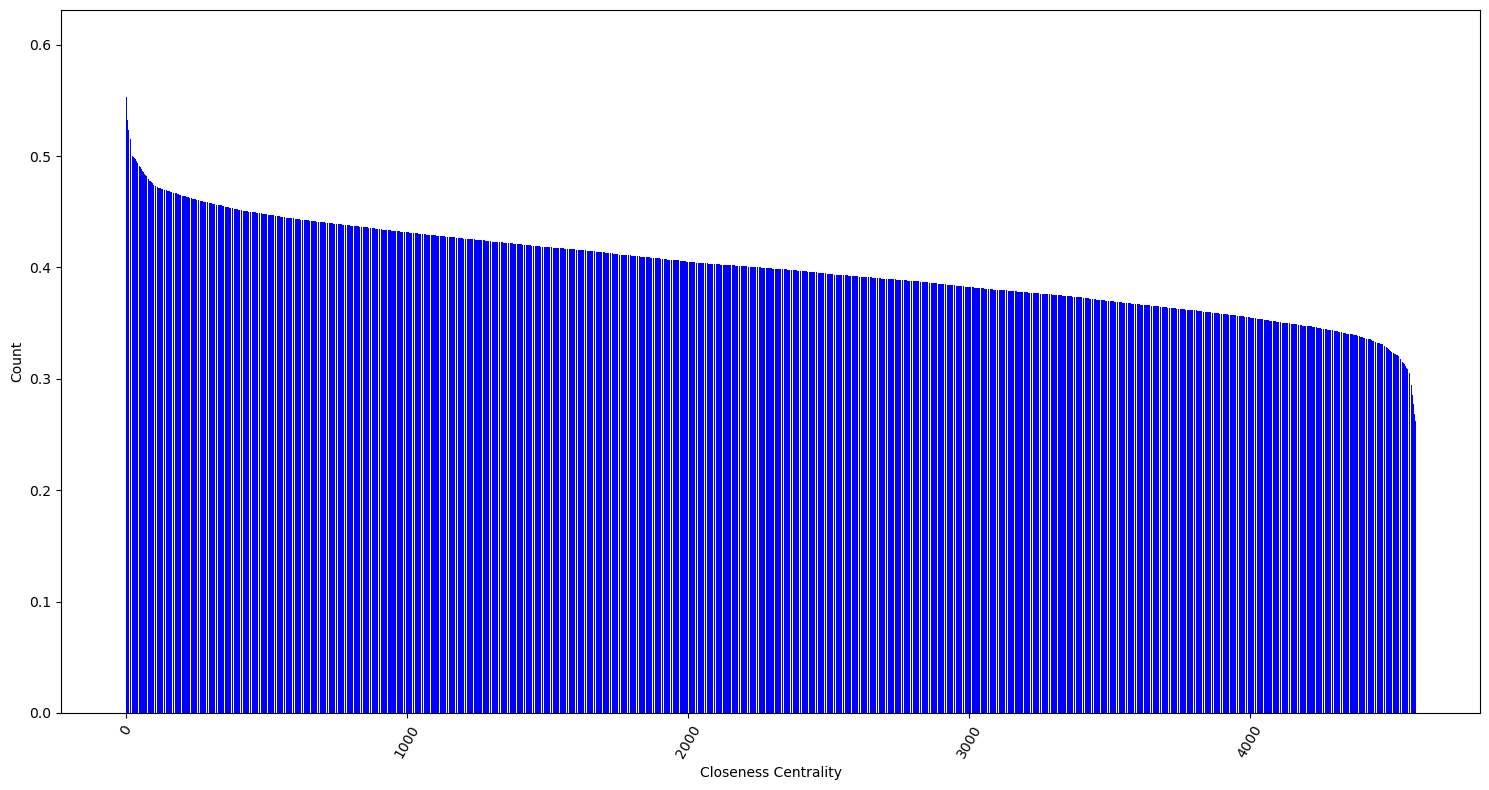

In [16]:
show_histogram(yvalues=[row[1] for row in triangles], figsize=(15,8), xlabel='Triangles')
show_histogram(yvalues=[row[1] for row in closeness], figsize=(15,8), xlabel='Closeness Centrality')

In [17]:
'''cliques = nx.enumerate_all_cliques(H)

# convert the cliques to a list of cliques
list_cliques = list(cliques)

print('cliques: ', list_cliques ) '''

"cliques = nx.enumerate_all_cliques(H)\n\n# convert the cliques to a list of cliques\nlist_cliques = list(cliques)\n\nprint('cliques: ', list_cliques ) "

## K-Core

In [10]:
H = nx.k_core(G)

In [11]:
nx.core_number(G)['English_language']

47

Se o main k-core contém o nó 'English_language', e o core number do nó 'English_language' é 47, então o main k-core é 47-core.
Fazendo um histograma das macro-categorias encontradas no k-core temos:

[('Geography', 156), ('Countries', 133), ('Citizenship', 15), ('History', 12), ('Business_Studies', 5), ('Language_and_literature', 5), ('Religion', 3), ('Everyday_life', 3), ('Science', 1), ('Design_and_Technology', 1), ('People', 1)]


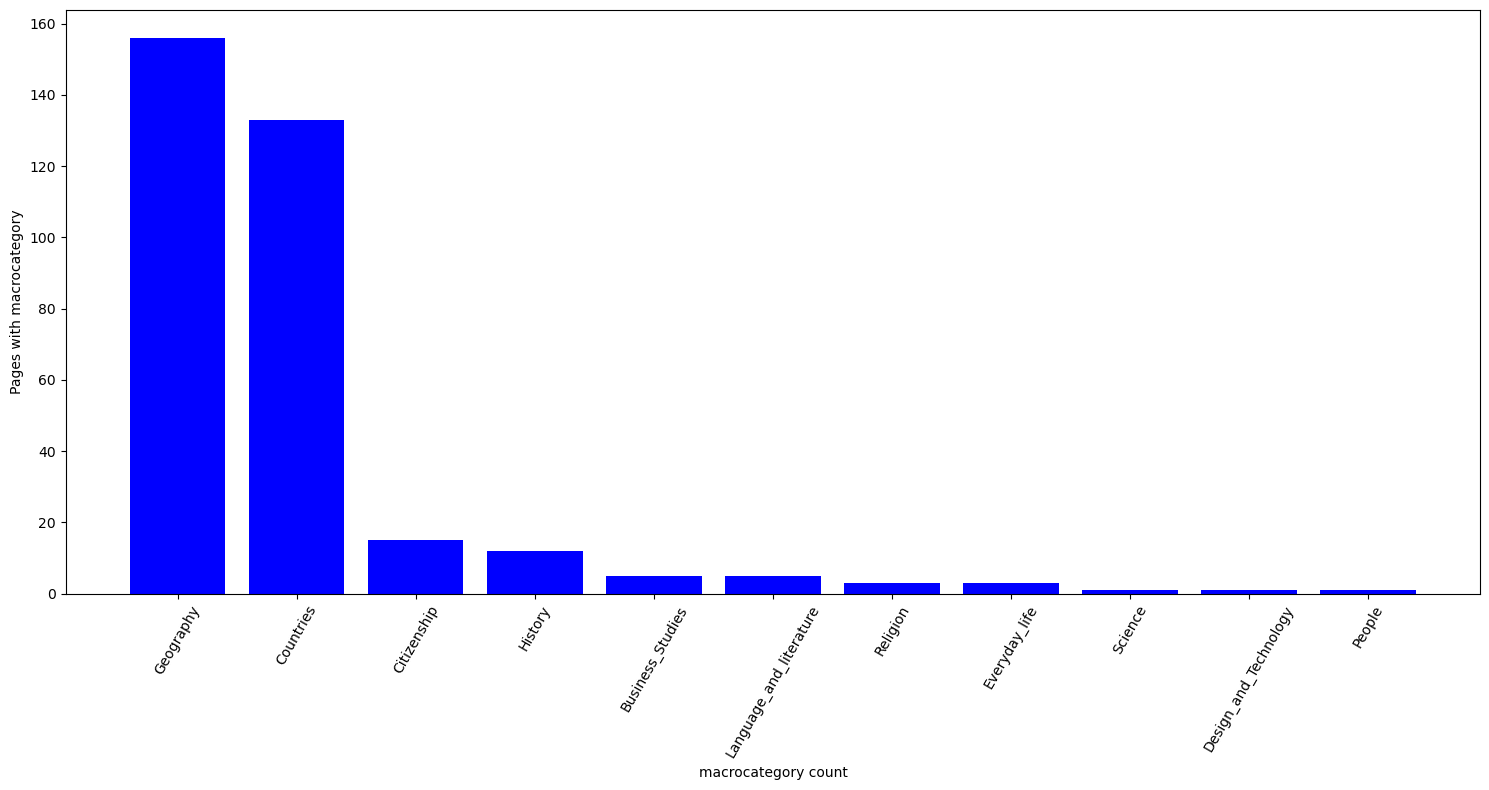

In [12]:
histogram_attribute(H, 'macrocategory')
#histogram_attribute(H, 'category')

## Menores caminhos vs Caminhos dos Jogadores

In [22]:
## Get all player paths and all origin/destiny pairs solved by the players
all_players_paths = [row.split('|') for row in df3[3].tolist()]
all_players_pairs = set([(row[0], row[len(row)-1]) for row in all_players_paths])

199

In [33]:
## Get all shortest paths for the origin/destiny pairs solved by the players
all_shortest_paths_tested = []
appthcp = all_players_paths.copy()
apprcp = all_players_pairs.copy()

for pair in all_players_pairs:
    try:
        sp = nx.shortest_path(G, source=pair[0], target=pair[1])
        all_shortest_paths_tested.append(sp)
    except:
        apprcp.remove(pair)
        for p in appthcp:
            if p[0] == pair[0] and p[len(p)-1] == pair[1]:
                all_players_paths.remove(p)

In [37]:
## Mean length of the paths (players and shotests)
length_shortest_paths = [len(row) for row in all_shortest_paths_tested]
length_players_paths = [len(row) for row in all_players_paths]
mean_shortest_paths_length = sum(length_shortest_paths)/len(length_shortest_paths)
mean_players_paths_length = sum(length_players_paths)/len(length_players_paths)

print(f'Tamanho médio dos menores caminhos: {mean_shortest_paths_length}')
print(f'Tamanho médio dos caminhos feitos pelos jogadores: {mean_players_paths_length}')

1.0

In [40]:
## Size of the longer path (players and shotests)
print(f'Tamanho do maior menor caminho: {max(length_shortest_paths)}')
print(f'Tamanho do maior caminho feito por um jogador: {max(length_players_paths)}')

,0,1,2,3,4
0,6a3701d319fc3754,1297740409,166,14th_century|15th_century|16th_century|Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century|Europe|Africa|Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century|Niger|Nigeria|British_Empire|Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century|Renaissance|Ancient_Greece|Greece,NaN
4,015245d773376aab,1366730828,175,14th_century|Italy|Roman_Catholic_Church|HIV|R...,3.0
...,...,...,...,...,...
51313,15a13a1d66ef5456,1349231015,66,Yagan|Ancient_Egypt|Civilization,NaN
51314,2ef7ac844cefda58,1300254138,165,Yagan|Folklore|Brothers_Grimm|<|19th_century|C...,3.0
51315,12863abb7887f890,1385095372,228,Yagan|Australia|England|France|United_States|T...,NaN
51316,19f8284371753362,1298792567,56,"Yarralumla,_Australian_Capital_Territory|Austr...",1.0


In [ ]:
## Histogram for the length of the shortest paths
plt.hist(np.array(length_shortest_paths), bins=[1, 2, 3, 4, 5, 6])
plt.show()

In [ ]:
## Histogram for the length of the players paths
plt.hist(np.array(length_players_paths), bins=range(0,50))
plt.show()

In [ ]:
import statistics as st

print(f'Moda do tamanho dos menores caminhos: {st.mode(length_shortest_paths)}')
print(f'Moda do tamanho dos caminhos dos jogadores: {st.mode(length_players_paths)}')

### Em termos de macro-categoria

In [ ]:
## Shortest paths
def get_attributes_of_path(graph, path, attribute):
    path_attrs = []
    for node in path:
        if G.has_node(node):
            attriute_values = nx.get_node_attributes(graph, name=attribute)[node]
            if attriute_values != None:
                path_attrs = path_attrs + attriute_values
    return path_attrs
    
# Taxa de salto de atributo (Ratio Attribute Hop - RAH). Quanto mais próximo de 1 menos saltos de atributo (categoria) houveram ao longo do caminho.
# Ou seja, uma taxa próxima a 1 significa que as categorias não variaram muito ao longo do caminho, 
# o caminho navegou por páginas de mesma categoria
# Se o valor for baixo significa que o caminho passou por páginas de categorias diversas
def ratio_attribute_hops(attributes_list):
    return len(set(attributes_list))/len(attributes_list)
    
def get_rha_for_paths(graph, paths, attribute):
    rah_list = []
    for path in paths: 
        rah_list.append(ratio_attribute_hops(get_attributes_of_path(graph, path, attribute)))
    return rah_list
    

In [ ]:
shortest_path_rha_list = get_rha_for_paths(G, all_shortest_paths_tested, 'macrocategory')

In [ ]:
player_path_rha_list = get_rha_for_paths(G, all_players_paths, 'macrocategory')

In [ ]:
print(f'RAH médio dos menores caminhos: {st.mean(shortest_path_rha_list)}')
print(f'RAH médio dos caminhos dos jogadores: {st.mean(player_path_rha_list)}')

In [ ]:
## Histogram for RAH of the shortest paths
plt.hist(np.array(shortest_path_rha_list))
plt.show()

In [ ]:
## Histogram for RAH of players paths
plt.hist(np.array(player_path_rha_list))
plt.show()